In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, random,sys, json,zipfile, time
from copy import deepcopy
import plotly.graph_objects as go
import math
from scipy.stats import spearmanr
import plotly.express as px
from scipy.optimize import minimize
#import smogn
from copy import deepcopy
import plotly.express as px
import numpy as np
from scipy.stats import gaussian_kde

In [2]:
#------------ Functions for prepocessing -----------------#
def convert_values_tol_log_scale(df_data):
  lista_log = ['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10', 'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10', 'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10','cycles']
  for el in lista_log:
    if (df_data[el]<0).any():
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(abs(x)))
    else:
      df_data[f'{el}'] = df_data[el].apply(lambda x: np.log10(x))
  return df_data


def convert_from_log_to_normal(actual,preds):
  pred_actual =  np.round(10**preds,decimals=0)
  values_actual = np.round(10**actual,decimals=0)
  return values_actual,pred_actual

In [3]:
WANTED_CYCLE = 100
init_df = pd.read_csv(f'/content/f_data_100_10.csv')
init_df.drop(columns = {'Unnamed: 0'},inplace=True)
init_df.columns

Index(['var_DQ_100_10', 'IQR_DQ_100_10', 'IDR_DQ_100_10', 'min_DQ_100_10',
       'maxDQ_100_10', 'mean_DQ_100_10', 'skew_100_10', 'kurt_100_10',
       'mean_cub_DQ_100_10', 'voltage_295_100_10', 'range_100_10',
       'average_charge_2_6', 'average_charge_2_WI', 'min_resistance_2_100',
       'diff_resistance_2_100', 'temperature_integral', 'discharge_cycle_2',
       'discharge_cycle_WI', 'slope_2_100', 'intercept_2_100', 'cycles',
       'diff_disc_cap_2_max'],
      dtype='object')

In [4]:
import plotly.graph_objects as go

var_ar_smoter = init_df['var_DQ_100_10'].values
cycles_ar_smoter = init_df['cycles'].values

cmap1 = plt.get_cmap('coolwarm')
colors_smoter = [cmap1(1 - (x - min(cycles_ar_smoter)) / (max(cycles_ar_smoter) - min(cycles_ar_smoter))) for x in cycles_ar_smoter]
plotly_colors = [f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 1)' for c in colors_smoter]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=var_ar_smoter,
    y=cycles_ar_smoter,
    mode='markers',
    marker=dict(size=22, color=plotly_colors, opacity=1)
))
fig.update_layout(
    title='Var ΔQ100_10 vs Cycle Life (SMOTER)',
    xaxis=dict(title='Var ΔQ100_10 (V)',  type = 'log',range=[-8, -1]),
    yaxis=dict(title='Cycle Life', type = 'log',range=[2, 4])
)
fig.show()

In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

def smoter(X, y, rel_thres=0.9, k=5, multiplier=5):
    X = X.reset_index(drop=True)
    y = np.array(y)
    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
    rare_mask = y_scaled >= rel_thres

    X_rare = X[rare_mask].reset_index(drop=True)
    y_rare = y[rare_mask]

    if len(X_rare) < 2:
        raise ValueError("Not enough rare samples.")

    k_neighbors = min(k, len(X_rare) - 1)
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(X_rare)

    synthetic_X = []
    synthetic_y = []

    for i in range(len(X_rare)):
        yi = y_rare[i]
        distances, indices = nn.kneighbors(X_rare.loc[[i]])
        neighbors = indices[0][1:]  # exclude self

        if len(neighbors) == 0:
            continue

        for _ in range(multiplier):
            idx = np.random.choice(neighbors)
            xi = X_rare.loc[i].values
            xj = X_rare.loc[idx].values
            yj = y_rare[idx]

            lam = np.random.rand()
            x_syn = xi + lam * (xj - xi)
            y_syn = yi + lam * (yj - yi)

            synthetic_X.append(dict(zip(X.columns, x_syn)))
            synthetic_y.append(y_syn)

    X_syn_df = pd.DataFrame(synthetic_X)
    y_syn_arr = np.array(synthetic_y)

    X_final = pd.concat([X, X_syn_df], ignore_index=True)
    y_final = np.concatenate([y, y_syn_arr])

    return X_final, y_final

In [6]:
smoter_df = init_df.copy()
cols_to_drop = ['cycle_bin', 'cycle_bin_label', 'average_charge_2_WI', 'discharge_cycle_WI']
smoter_df.drop(columns=[col for col in cols_to_drop if col in smoter_df.columns], inplace=True)

smoter_df = convert_values_tol_log_scale(smoter_df)

X = smoter_df.drop(columns=['cycles'])
y = smoter_df['cycles']

mid_mask = (y >= y.quantile(0.3)) & (y <= y.quantile(0.7))
X = X[~mid_mask]
y = y[~mid_mask]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_smoter, y_smoter = smoter(X_train, y_train, rel_thres=0.8, k=9, multiplier=5)

smoter_dataframe = X_smoter.copy()
smoter_dataframe['cycles'] = y_smoter

In [7]:
X_smoter_all, y_smoter_all = smoter(X, y, rel_thres=0.8, k=9, multiplier=5)

normal_var_ar_smoter = X_smoter_all['var_DQ_100_10'].values
normal_cycles_ar_smoter = y_smoter_all

var_ar_smoter = 10**normal_var_ar_smoter
cycles_ar_smoter = np.round(10**normal_cycles_ar_smoter,decimals = 0)

cmap1 = plt.get_cmap('coolwarm')
colors_smoter = [cmap1(1 - (x - min(cycles_ar_smoter)) / (max(cycles_ar_smoter) - min(cycles_ar_smoter))) for x in cycles_ar_smoter]
plotly_colors = [f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 1)' for c in colors_smoter]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=var_ar_smoter,
    y=cycles_ar_smoter,
    mode='markers',
    marker=dict(size=22, color=plotly_colors, opacity=1)
))
fig.update_layout(
    title='Var ΔQ100_10 vs Cycle Life (SMOTER)',
    xaxis=dict(title='Var ΔQ100_10 (V)', type = 'log', range=[-8, -1]),
    yaxis=dict(title='Cycle Life', type = 'log', range=[2, 4])
)
fig.show()

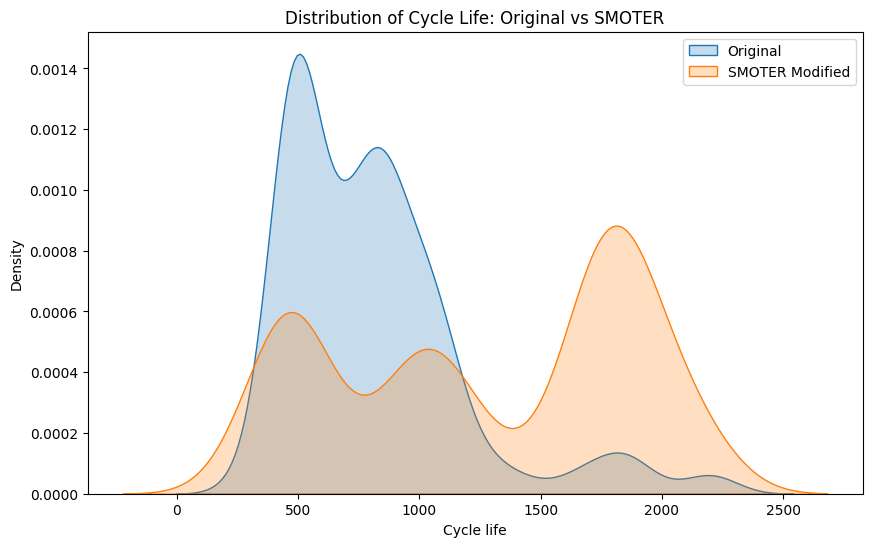

In [8]:
official_cycles = np.round(10**smoter_df['cycles'],decimals = 0)
SMOTER_cycles = np.round(10**smoter_dataframe['cycles'],decimals = 0)

plt.figure(figsize=(10, 6))

sns.kdeplot(official_cycles, label='Original', fill=True, bw_adjust=0.7)
sns.kdeplot(SMOTER_cycles, label='SMOTER Modified', fill=True, bw_adjust=0.7)

plt.xlabel("Cycle life")
plt.ylabel("Density")
plt.title("Distribution of Cycle Life: Original vs SMOTER")
plt.legend()
plt.show()

In [9]:
cycle_log = cycles_ar_smoter
var_log = var_ar_smoter
pear_corr = np.corrcoef(var_log, cycle_log)[0, 1]

print(f"Pearson correlation (log-log scale): {pear_corr:.4f}")

Pearson correlation (log-log scale): -0.6211


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


# ----------- Hyperparameter Tuning: ElasticNet & RandomForest -----------
parameter_elastic_net = {
    'alpha': [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.9, 1.0],
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.78, 0.8, 0.82, 0.85, 0.86, 0.9]
}

parameters_random_forests = {
    'n_estimators': [1, 3, 5, 10, 30, 50, 100],
    'criterion': ['absolute_error'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5]
}

grid_search_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=5000),
    param_grid=parameter_elastic_net,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1, verbose=0
)

grid_search_forest = GridSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    param_grid=parameters_random_forests,
    scoring='neg_mean_absolute_error',
    cv=5, n_jobs=-1, verbose=0
)

In [11]:
# ----------- Fit Models -----------
grid_search_elastic.fit(X_smoter, y_smoter)
grid_search_forest.fit(X_smoter, y_smoter )

best_model_ELA = grid_search_elastic.best_estimator_
best_model_FOREST = grid_search_forest.best_estimator_

print("Best ElasticNet Params:", grid_search_elastic.best_params_)
print("Best RandomForest Params:", grid_search_forest.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.594e-02, tolerance: 5.571e-04



Best ElasticNet Params: {'alpha': 1e-06, 'l1_ratio': 0.9}
Best RandomForest Params: {'criterion': 'absolute_error', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [12]:
# ----------- Predict & Evaluate -----------
preds_test_ELA = best_model_ELA.predict(X_test)
preds_test_FOREST = best_model_FOREST.predict(X_test)

In [13]:
preds_test_ELA = best_model_ELA.predict(X_test)
preds_test_FOREST = best_model_FOREST.predict(X_test)

actual_test, pred_test_ela = convert_from_log_to_normal(y_test, preds_test_ELA)
_, pred_test_forest = convert_from_log_to_normal(y_test, preds_test_FOREST)

print(f"\nMAE (ElasticNet) on test set: {mean_absolute_error(actual_test, pred_test_ela):.2f}")
print(f"MAE (RandomForest) on test set: {mean_absolute_error(actual_test, pred_test_forest):.2f}")


MAE (ElasticNet) on test set: 121.74
MAE (RandomForest) on test set: 53.35


In [14]:
from sklearn.metrics import mean_squared_error

rmse_forest = np.sqrt( mean_squared_error(actual_test, pred_test_forest))

In [15]:
print(f"\n RMSE (Random forest) on test set: {rmse_forest:.2f}")


 RMSE (Random forest) on test set: 90.73


In [16]:
ela_forest = np.sqrt( mean_squared_error(actual_test, pred_test_ela))

print(f"\n RMSE (Elastic Net) on test set: {ela_forest:.2f}")


 RMSE (Elastic Net) on test set: 274.63
